# ABC calibration of $I_\text{Na}$ in Courtemanche model to original dataset.

In [4]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [6]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used in the publication:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant [Sakakibara1992]
 - Recovery time constant [Sakakibara1992]

In [1]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/courtemanche_ina.mmt'

# Activation gate ($m$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [7]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum)

In [8]:
assert len(observations)==len(summary_statistics(model({})))

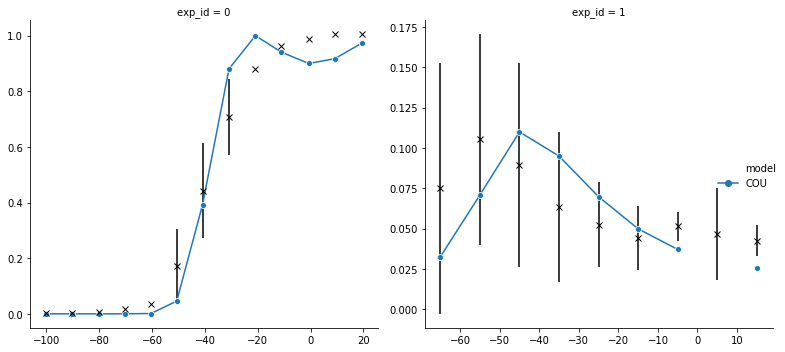

In [9]:
# Test the output of the unaltered model.
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [10]:
limits = {'ina.a1_m': (-100, 0),
          'ina.a2_m': (0, 1),
          'ina.a3_m': (0, 1),
          'ina.a4_m': (0, 10),
          'ina.b1_m': (0, 10),
          'ina.b2_m': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_mgate_original.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5570757359362264, '1': 1.5570757359362264, '2': 1.5570757359362264, '3': 1.5570757359362264, '4': 1.5570757359362264, '5': 0.5904911622959486, '6': 0.45939980914873735, '7': 0.5710013425594168, '8': 1.5570757359362264, '9': 1.5570757359362264, '10': 1.5570757359362264, '11': 1.5570757359362264, '12': 1.5570757359362264, '13': 0.15235445469736852, '14': 0.1819349064747563, '15': 0.1879980741832115, '16': 0.25507625823484376, '17': 0.4491978085688121, '18': 0.5936989296806218, '19': 1.3185718986681156, '20': 0.4160669679218102, '21': 1.2534510282040947}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-23 17:07:35.760566, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [17]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 996
DEBUG:Epsilon:new eps, t=1, eps=1.0311347633808372
INFO:ABC:t:1 eps:1.0311347633808372
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 2026
DEBUG:Epsilon:new eps, t=2, eps=0.7597488221321739
INFO:ABC:t:2 eps:0.7597488221321739
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 3194
DEBUG:Epsilon:new eps, t=3, eps=0.6487851633963204
INFO:ABC:t:3 eps:0.6487851633963204
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4462
DEBUG:Epsilon:new eps, t=4, eps=0.5598610116739912
INFO:ABC:t:4 eps:0.5598610116739912
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 5809
DEBUG:Epsilon:new eps, t=5, eps=0.49570040317337

### Analysis of results

In [12]:
history = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_mgate_original.db')

In [13]:
df, w = history.get_distribution(m=0)

In [14]:
df.describe()

name,ina.a1_m,ina.a2_m,ina.a3_m,ina.a4_m,ina.b1_m,ina.b2_m
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-75.965570,0.263684,0.425783,5.280118,1.256067,23.190074
std,1.212495,0.005259,0.206499,2.675867,0.020556,0.269596
min,-80.391776,0.245459,0.181787,0.065253,1.188147,22.475140
25%,-76.507571,0.261949,0.244972,3.087968,1.244613,23.001919
50%,-75.932036,0.264021,0.358607,5.110668,1.257705,23.178370
75%,-75.406982,0.265708,0.567087,7.649022,1.267700,23.326681
max,-72.356660,0.279732,0.995361,9.997961,1.327389,24.150420


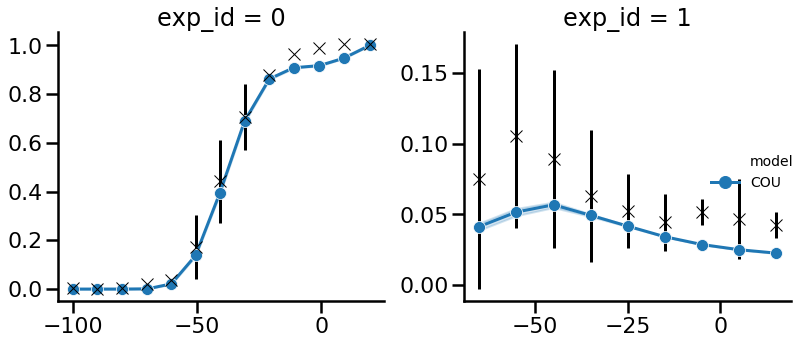

In [15]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     df=df, w=w)

plt.tight_layout()

In [16]:
m,_,_ = myokit.load(modelfile)

In [17]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

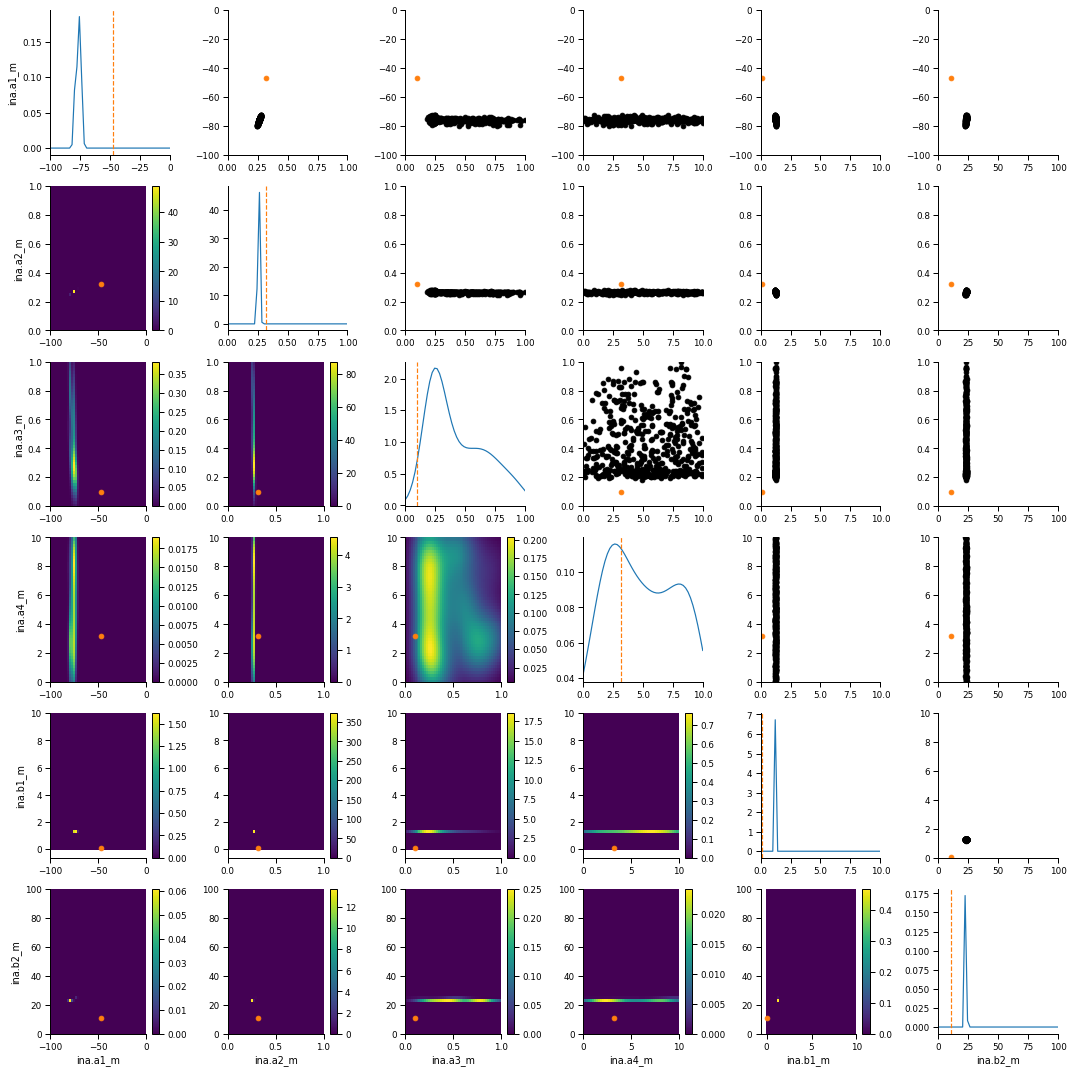

In [18]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Fast inactivation gate ($h$) calibration

In [19]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast)

In [20]:
assert len(observations)==len(summary_statistics(model({})))

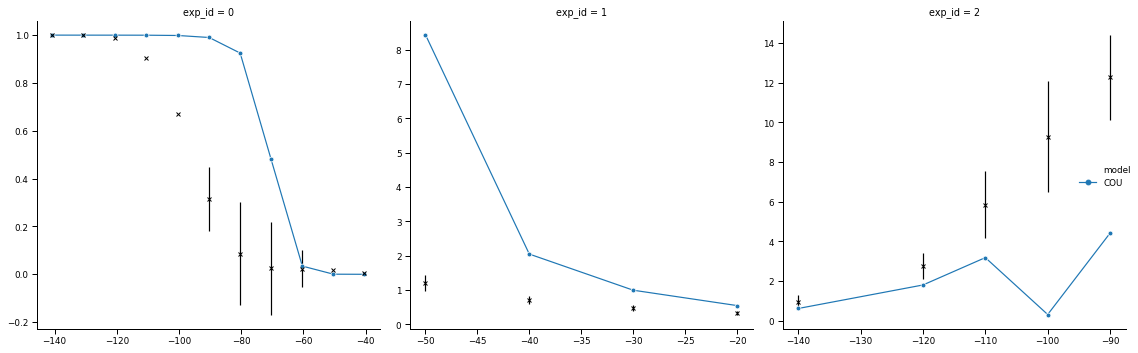

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast)

In [68]:
limits = {'ina.c1_h': (-100, 0),
          'log_ina.a1_h': (-2, 1),
          'ina.a2_h': (0, 50),
          'ina.a3_h': (0, 200),
          'ina.b2_h': (0, 100),
          'ina.b3_h': (0, 50),
          'log_ina.b4_h': (-1, 2),
          'log_ina.b5_h': (-3, 0),
          'log_ina.b6_h': (3, 6),
          'log_ina.b7_h': (-2, 1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [6]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_hgate_original.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9298311489289642, '1': 0.9298311489289642, '2': 0.9298311489289642, '3': 0.9298311489289642, '4': 0.9298311489289642, '5': 0.34877521029031383, '6': 0.21674341481487852, '7': 0.24006575158114657, '8': 0.5989135286482826, '9': 0.9298311489289642, '10': 0.9298311489289642, '11': 0.6679914857297752, '12': 1.3151082375304948, '13': 1.8297158087380803, '14': 2.5570356595546513, '15': 2.0456285276437214, '16': 1.901285628941935, '17': 0.7393593039114589, '18': 0.44622757416898995, '19': 0.5843318259435246}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-24 18:10:55.196815, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:15 eps:0.5038633058529319
DEBUG:ABC:now submitting population 15


### Database results analysis

In [69]:
history = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_hgate_original.db')

In [70]:
history.all_runs() # most recent run should be used

[<ABCSMC(id=1, start_time=2019-09-24 18:10:55.196815, end_time=2019-09-25 05:00:49.313710)>,
 <ABCSMC(id=2, start_time=2019-09-25 09:33:45.116794, end_time=2019-09-29 23:46:31.472322)>]

In [71]:
df, w = history.get_distribution(m=0)

In [72]:
df.describe()

name,ina.a2_h,ina.a3_h,ina.b2_h,ina.b3_h,ina.c1_h,log_ina.a1_h,log_ina.b4_h,log_ina.b5_h,log_ina.b6_h,log_ina.b7_h
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,15.627484,117.723710,20.591884,15.527716,-41.574421,-0.546374,1.177778,-1.237163,4.749208,0.373651
std,0.347905,22.427037,7.133076,2.471212,5.923283,0.620450,0.011225,0.003585,0.707234,0.365110
min,14.486852,64.500240,0.293657,11.263442,-58.123860,-1.998133,1.142843,-1.248021,3.000184,-0.556649
25%,15.424090,102.764118,15.711472,13.543166,-46.856111,-0.965005,1.170097,-1.239634,4.259559,0.121587
50%,15.677370,118.132372,22.901233,14.746011,-39.563764,-0.529836,1.177726,-1.237178,4.799034,0.415820
75%,15.873789,133.503225,26.197578,17.431789,-36.513025,-0.115891,1.185437,-1.234729,5.287091,0.660151
max,16.409736,175.434654,31.855868,22.895112,-32.907733,0.993192,1.211868,-1.226734,5.998103,0.998697


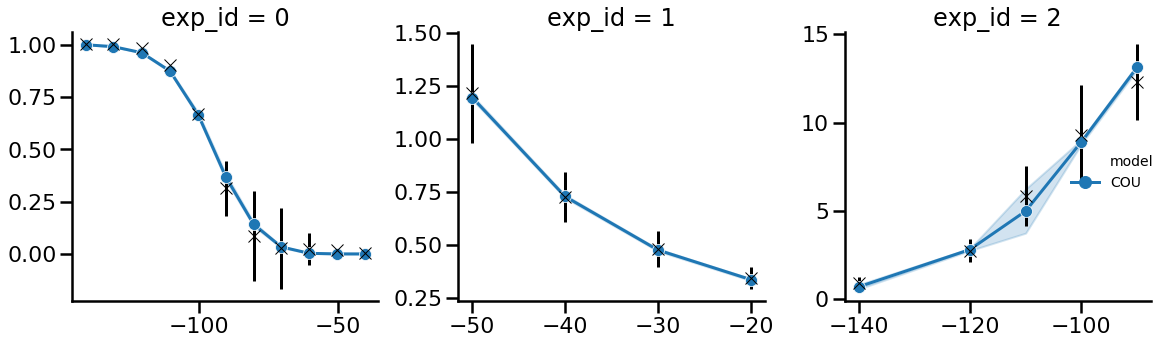

In [34]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df, w=w)

plt.tight_layout()

In [45]:
m,_,_ = myokit.load(modelfile)

In [73]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

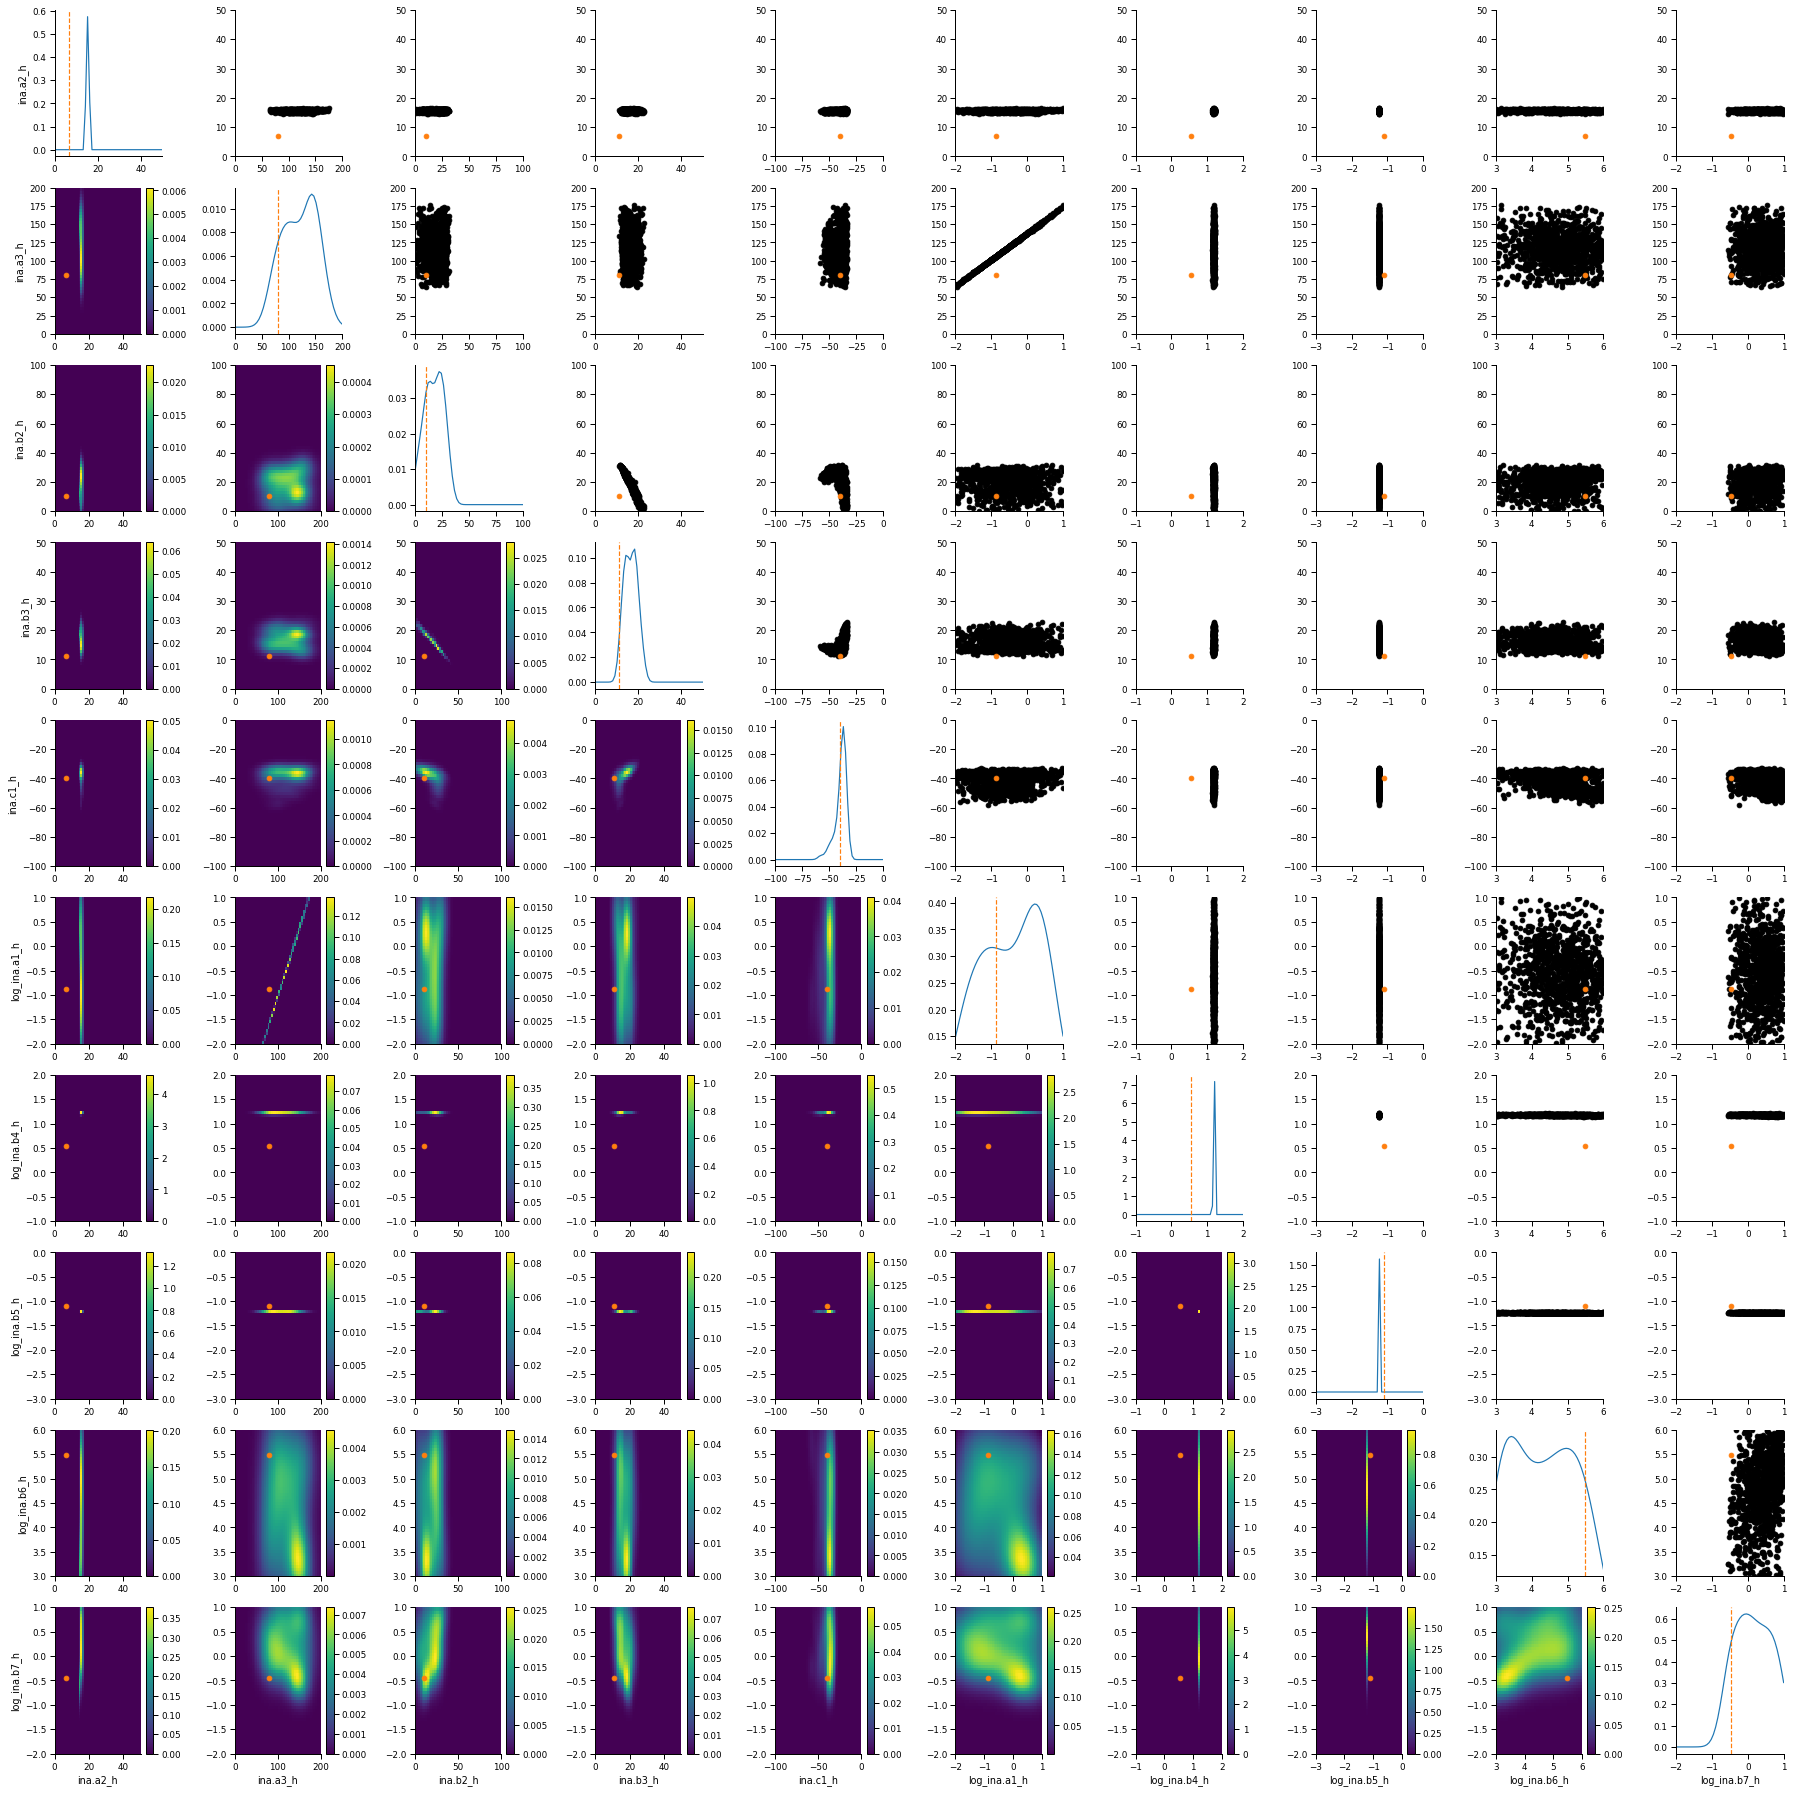

In [74]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Slow inactivation gate ($j$) calibration

In [51]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_slow,
                                                sakakibara_rec_slow)

In [52]:
assert len(observations)==len(summary_statistics(model({})))

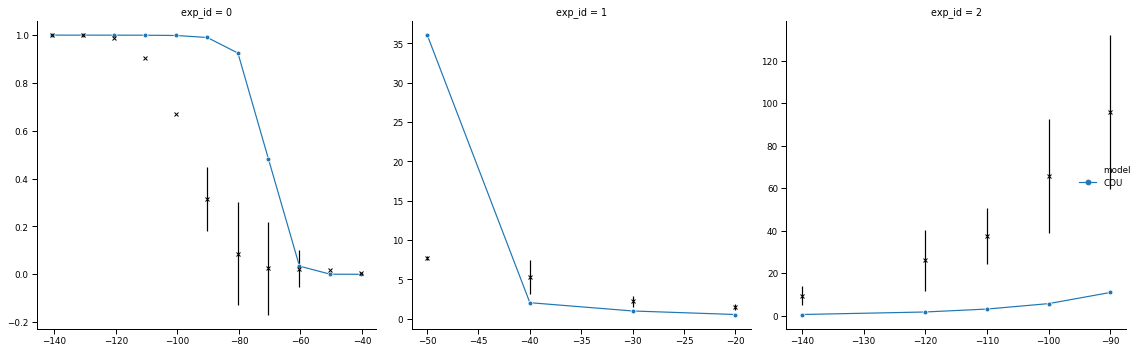

In [53]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow)

In [75]:
limits = {'ina.c1_j': (-100, 0),
          'log_ina.a1_j': (4, 7),
          'log_ina.a2_j': (-2, 1),
          'log_ina.a3_j': (-6, -4),
          'log_ina.a4_j': (-3, -1),
          'ina.a5_j': (0, 100),
          'ina.a6_j': (0, 1),
          'ina.a7_j': (0, 100),
          'log_ina.b2_j': (-8, -6),
          'ina.b3_j': (0, 1),
          'ina.b4_j': (0, 100),
          'log_ina.b5_j': (-2, 1),
          'log_ina.b6_j': (-3, -1),
          'ina.b7_j': (0, 1),
          'ina.b8_j': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [ ]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ina_jgate_original.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9818869939747233, '1': 0.9818869939747233, '2': 0.9818869939747233, '3': 0.9818869939747233, '4': 0.9818869939747233, '5': 0.3683011084316996, '6': 0.2288776196425918, '7': 0.25350563857514163, '8': 0.6324432182903594, '9': 0.9818869939747233, '10': 0.9818869939747233, '11': 2.700189233430489, '12': 0.4957538129507886, '13': 1.412898366909747, '14': 2.700189233430489, '15': 2.160151386744391, '16': 0.7192132991083816, '17': 0.7852456348032116, '18': 0.3846095367327172, '19': 0.2854129531269287}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-10 21:48:55.790823, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Analysis of results

In [76]:
history = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_jgate_original.db')

In [77]:
df, w = history.get_distribution(m=0)

In [78]:
df.describe()

name,ina.a5_j,ina.a6_j,ina.a7_j,ina.b3_j,ina.b4_j,ina.b7_j,ina.b8_j,ina.c1_j,log_ina.a1_j,log_ina.a2_j,log_ina.a3_j,log_ina.a4_j,log_ina.b2_j,log_ina.b5_j,log_ina.b6_j
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,80.807866,0.497264,26.525363,0.513554,72.612164,0.080114,47.449398,-46.322013,5.498791,0.305335,-4.575865,-1.521339,-7.003548,-1.046110,-2.115565
std,2.600955,0.256976,14.755990,0.255469,17.720566,0.014721,17.680287,17.622792,0.792269,0.378466,0.231757,0.061847,0.546752,0.495240,0.410408
min,72.088202,0.014454,0.010151,0.000062,3.315809,0.048495,0.130817,-82.731178,4.002777,-0.594460,-5.191463,-1.708443,-7.998241,-1.999135,-2.999992
25%,79.025309,0.298118,14.549681,0.311176,64.550693,0.069126,36.716561,-59.083654,4.862971,0.020619,-4.740816,-1.564127,-7.450188,-1.377894,-2.432952
50%,81.012524,0.483270,26.477893,0.516020,74.499173,0.078765,51.633864,-51.716229,5.488749,0.326044,-4.568108,-1.518877,-7.006902,-1.139196,-2.092743
75%,82.767607,0.708854,37.784231,0.716744,85.396514,0.089236,61.216689,-36.511735,6.138701,0.610460,-4.403488,-1.476861,-6.559422,-0.787466,-1.786023
max,87.380028,0.999091,68.337323,0.999626,99.995148,0.143996,83.310929,-0.100871,6.997853,0.997918,-4.004220,-1.367696,-6.000719,0.760711,-1.250646


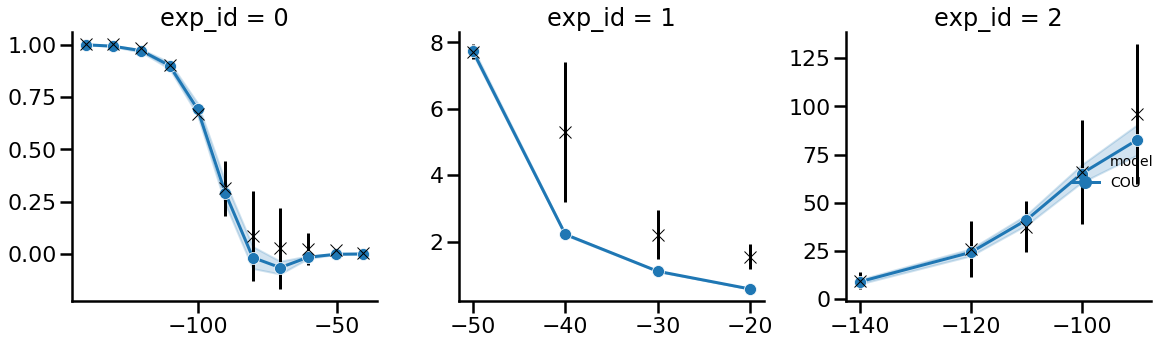

In [60]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow,
                     df=df, w=w)

plt.tight_layout()

In [79]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [80]:
m,_,_ = myokit.load(modelfile)

In [81]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

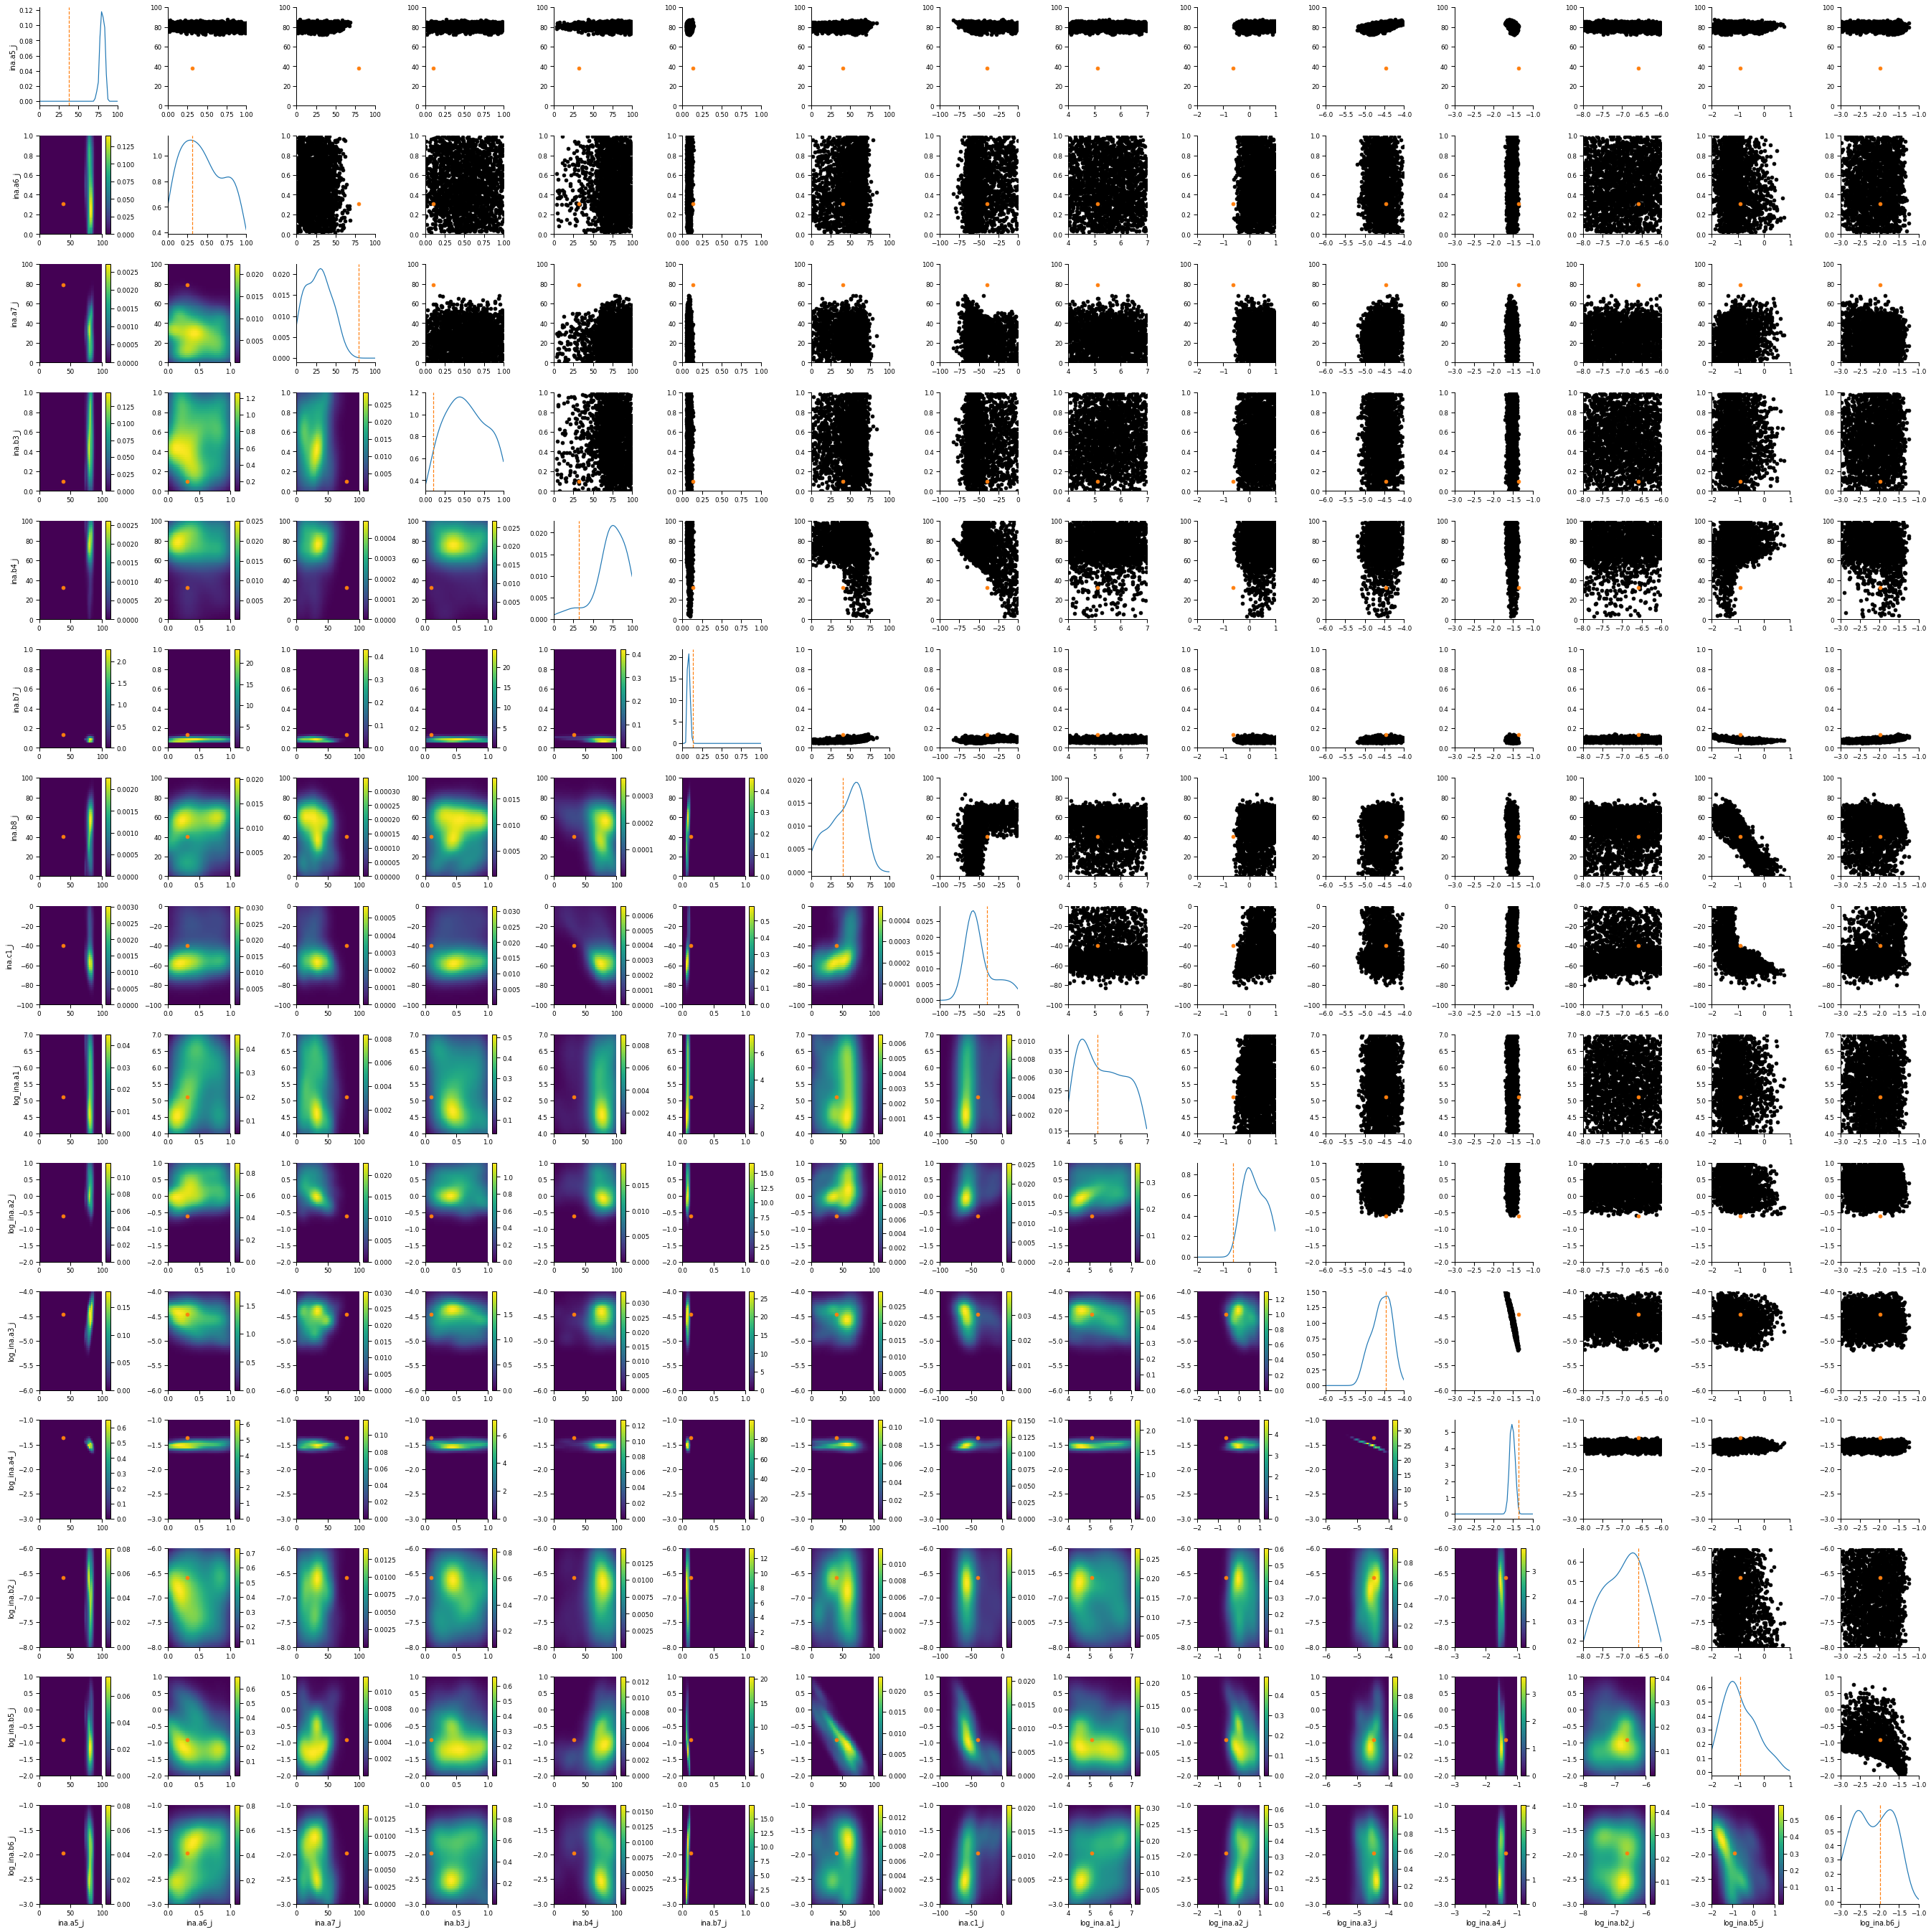

In [82]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)